Training ARIMA model...
Training LSTM model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1729
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 16/20
25/25 

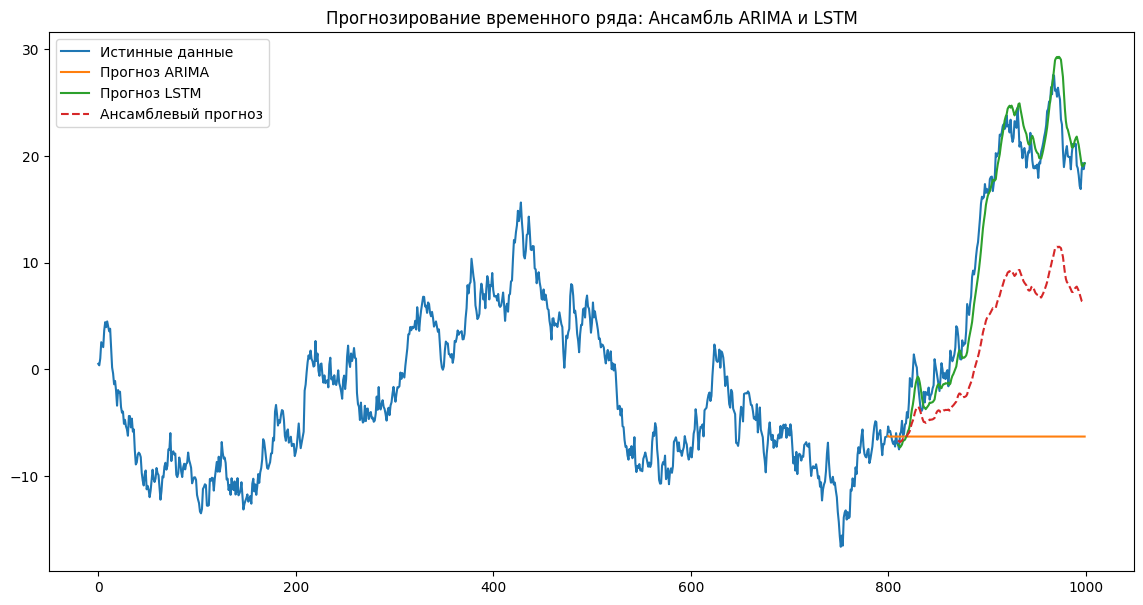

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Создаем искусственный временной ряд
np.random.seed(42)
time_series = np.cumsum(np.random.randn(1000))  # Пример временного ряда

# Разделяем данные на обучение и тест
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

# Масштабируем данные для модели LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

# ---- ARIMA ----
print("Training ARIMA model...")
arima_model = ARIMA(train, order=(5, 1, 0))  # Параметры ARIMA
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# ---- LSTM ----
# Функция для создания выборок с окнами временных рядов
def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Создаем и обучаем LSTM-модель
print("Training LSTM model...")
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, verbose=1)

# Прогнозирование с использованием LSTM
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# ---- Ансамблевый прогноз ----
# Приводим длину прогнозов к одному размеру
arima_forecast_aligned = arima_forecast[:len(lstm_forecast)]
ensemble_forecast = (arima_forecast_aligned + lstm_forecast.flatten()) / 2

# ---- Оценка результатов ----
plt.figure(figsize=(14, 7))
plt.plot(range(len(time_series)), time_series, label='Истинные данные')
plt.plot(range(train_size, train_size + len(test)), arima_forecast, label='Прогноз ARIMA')
plt.plot(range(train_size + window_size, train_size + window_size + len(lstm_forecast)), lstm_forecast, label='Прогноз LSTM')
plt.plot(range(train_size + window_size, train_size + window_size + len(ensemble_forecast)), ensemble_forecast, label='Ансамблевый прогноз', linestyle='--')
plt.legend()
plt.title("Прогнозирование временного ряда: Ансамбль ARIMA и LSTM")
plt.show()
